MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8860.7657820	test: 8855.9555343	best: 8855.9555343 (0)	total: 1.69ms	remaining: 1.69s
1:	learn: 8439.9668887	test: 8440.9009951	best: 8440.9009951 (1)	total: 2.94ms	remaining: 1.47s
2:	learn: 7975.0481484	test: 8005.6623171	best: 8005.6623171 (2)	total: 4.33ms	remaining: 1.44s
3:	learn: 7696.9225857	test: 7739.6075295	best: 7739.6075295 (3)	total: 5.59ms	remaining: 1.39s
4:	learn: 7368.5387340	test: 7433.1584439	best: 7433.1584439 (4)	total: 6.71ms	remaining: 1.33s
5:	learn: 7105.0342386	test: 7178.3905389	best: 7178.3905389 (5)	total: 7.87ms	remaining: 1.3s
6:	learn: 6789.3552282	test: 6886.4062662	best: 6886.4062662 (6)	total: 9.11ms	remaining: 1.29s
7:	learn: 6560.3165443	test: 6688.3980848	best: 6688.3980848 (7)	total: 10.2ms	remaining: 1.27s
8:	learn: 6354.3787613	test: 6501.5764025	best: 6501.5764025 (8)	total: 12.2ms	remaining: 1.34s
9:	learn: 6186.2561526	test: 6340.3526591	best: 6340.3526591 (9)	total: 13.8ms	remaining: 1.36s
10:	learn: 6038.6714562	test: 6195.806535

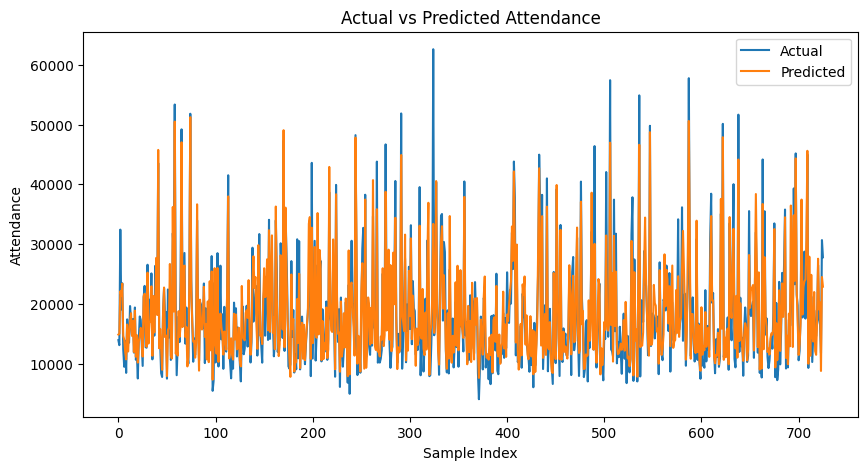

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('filtered_data_final.csv')

# 将 num_broadcasters 列中的 '5+' 替换为 '5'，并转换为 int64 类型
df['num_broadcasters'] = df['num_broadcasters'].replace('5+', '5').astype(int)

# 将 match_datetime 列转换为 datetime 类型
df['match_datetime'] = pd.to_datetime(df['match_datetime'])

# 按 match_datetime 排序
df.sort_values('match_datetime', inplace=True)

# 提取时间特征
df['year'] = df['match_datetime'].dt.year
df['month'] = df['match_datetime'].dt.month
df['day'] = df['match_datetime'].dt.day
df['hour'] = df['match_datetime'].dt.hour

# 删除原始的 match_datetime 列
df.drop(columns=['match_datetime'], inplace=True)

# 定义特征和目标
X = df.drop(columns=['attendance'])
y = df['attendance']

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建 CatBoost Pool
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

# 创建 CatBoost 回归模型
model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    eval_metric='RMSE',
    random_seed=42,
    logging_level='Verbose',
    early_stopping_rounds=100
)

# 训练模型
model.fit(train_pool, eval_set=test_pool, plot=True)

# 预测
y_pred = model.predict(X_test)

# 评估模型
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse:.4f}')
print(f'R² Score: {r2:.4f}')

# 可视化实际值和预测值
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Attendance')
plt.title('Actual vs Predicted Attendance')
plt.show()


# Use Optuna


1. **depth**:
   - 决定每棵树的最大深度。
   - 较大的深度可以捕捉更多的细节，但可能导致过拟合。较小的深度可能不足以捕捉复杂的模式。
   - 搜索范围设为4到10，通过试验不同的深度找到最佳值。

2. **l2_leaf_reg**:
   - L2正则化系数，用于防止过拟合。
   - 对叶节点权重进行惩罚，以限制模型的复杂度。
   - 使用对数均匀分布在0.01到10之间采样，较小的值提供更少的正则化，较大的值提供更多的正则化。

3. **border_count**:
   - 分箱数，用于将连续特征离散化。
   - 较多的分箱可以更精细地表示特征分布，但也增加计算复杂度。
   - 设置为32到255之间的整数，通过试验不同的分箱数找到最佳值。

4. **bagging_temperature**:
   - 控制随机选择样本时的多样性。
   - 较高的值使得样本选择更随机，有助于防止过拟合。
   - 在0.0到1.0之间浮动，通过试验找到最佳的bagging温度。

5. **random_strength**:
   - 在树结构中引入随机噪声的强度。
   - 较高的值增加模型的鲁棒性，但可能影响准确性。
   - 设置为0.0到1.0之间，通过试验找到最佳的随机强度。

6. **one_hot_max_size**:
   - 决定one-hot编码时类别数量的上限。
   - 如果类别数量超过此值，则使用其他编码方法（如target encoding）。
   - 搜索范围为2到10，通过试验找到最佳的one-hot编码最大值。


[I 2024-06-22 21:25:48,961] A new study created in memory with name: no-name-1ad6b193-0d75-4255-ab2d-8de514bd8122
C:\Users\29724\AppData\Local\Temp\ipykernel_14164\3870666897.py:44: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),
C:\Users\29724\AppData\Local\Temp\ipykernel_14164\3870666897.py:46: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10),
[I 2024-06-22 21:25:49,659] Trial 0 finished with value: 0.7908188461864714 and parameters: {'iterations': 673, 'learning_rate': 0.020459821173573606, 'depth': 5, 'l2_leaf_reg': 0.658176772680829, '

Best trial:
  Value: 0.8346634496028512
  Params: 
    iterations: 984
    learning_rate: 0.08211894473053545
    depth: 4
    l2_leaf_reg: 0.16082341507492298
    border_count: 250
    bagging_temperature: 0.9601249038813096
    random_strength: 0.0005434718802796307
    one_hot_max_size: 2


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 8933.2970795	test: 8910.0268674	best: 8910.0268674 (0)	total: 1.41ms	remaining: 1.38s
1:	learn: 8521.6421473	test: 8510.2637237	best: 8510.2637237 (1)	total: 2.85ms	remaining: 1.4s
2:	learn: 8158.0456478	test: 8154.3638437	best: 8154.3638437 (2)	total: 4.03ms	remaining: 1.32s
3:	learn: 7814.2356066	test: 7824.6005936	best: 7824.6005936 (3)	total: 5.06ms	remaining: 1.24s
4:	learn: 7512.0325677	test: 7534.8776523	best: 7534.8776523 (4)	total: 6.31ms	remaining: 1.24s
5:	learn: 7247.2963947	test: 7281.5034118	best: 7281.5034118 (5)	total: 7.37ms	remaining: 1.2s
6:	learn: 7016.5264065	test: 7065.3110255	best: 7065.3110255 (6)	total: 8.32ms	remaining: 1.16s
7:	learn: 6818.6299881	test: 6875.9703184	best: 6875.9703184 (7)	total: 9.42ms	remaining: 1.15s
8:	learn: 6635.6461228	test: 6708.5231466	best: 6708.5231466 (8)	total: 11ms	remaining: 1.19s
9:	learn: 6477.0134899	test: 6563.6023780	best: 6563.6023780 (9)	total: 12.3ms	remaining: 1.2s
10:	learn: 6341.4865952	test: 6441.5566979	be

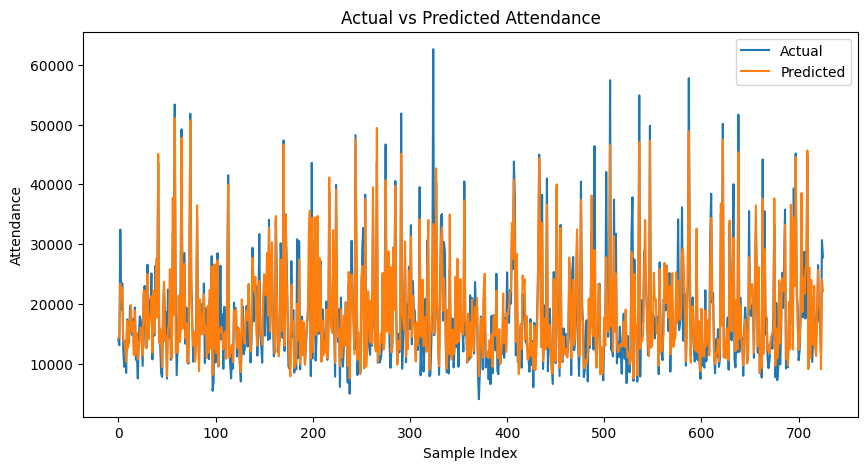

In [7]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
from catboost import CatBoostRegressor, Pool
from sklearn.metrics import r2_score
import optuna
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('filtered_data_final.csv')

# 将 num_broadcasters 列中的 '5+' 替换为 '5'，并转换为 int64 类型
df['num_broadcasters'] = df['num_broadcasters'].replace('5+', '5').astype(int)

# 将 match_datetime 列转换为 datetime 类型
df['match_datetime'] = pd.to_datetime(df['match_datetime'])

# 按 match_datetime 排序
df.sort_values('match_datetime', inplace=True)

# 提取时间特征
df['year'] = df['match_datetime'].dt.year
df['month'] = df['match_datetime'].dt.month
df['day'] = df['match_datetime'].dt.day
df['hour'] = df['match_datetime'].dt.hour

# 删除原始的 match_datetime 列
df.drop(columns=['match_datetime'], inplace=True)

# 定义特征和目标
X = df.drop(columns=['attendance'])
y = df['attendance']

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 创建 CatBoost Pool
train_pool = Pool(data=X_train, label=y_train)
test_pool = Pool(data=X_test, label=y_test)

# 定义目标函数
def objective(trial):
    # 定义超参数的搜索空间
    param = {
        'iterations': trial.suggest_int('iterations', 100, 1000),  # 迭代次数
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-4, 1e-1),  # 学习率

        'depth': trial.suggest_int('depth', 4, 10),  
        # 树的深度（depth）：决定每棵树可以增长的最大深度。
        # 较大的深度可以使模型捕捉更多的细节，但也可能导致过拟合。
        # 在这里，我们设置了搜索范围为4到10，试图找到一个平衡点。

        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10),  
        # L2正则化系数（l2_leaf_reg）：用于防止过拟合的L2正则化项。
        # 它会对叶节点权重进行惩罚，以限制模型的复杂度。
        # 在这里，我们设置了搜索范围为0.01到10，通过对数均匀分布进行采样。

        'border_count': trial.suggest_int('border_count', 32, 255),  
        # 分箱数（border_count）：用于将连续特征离散化的分箱数量。
        # 更多的分箱可以提供更精细的特征分布，但也会增加计算复杂度。
        # 在这里，我们设置了搜索范围为32到255。

        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),  
        # Bagging温度（bagging_temperature）：控制随机选择样本时的多样性。
        # 值越高，样本选择越随机，越有助于防止过拟合。
        # 在这里，我们设置了搜索范围为0.0到1.0。

        'random_strength': trial.suggest_float('random_strength', 0.0, 1.0),  
        # 随机强度（random_strength）：在树结构中引入随机噪声的强度。
        # 更高的随机强度可以增加模型的鲁棒性，但也可能影响准确性。
        # 在这里，我们设置了搜索范围为0.0到1.0。

        'one_hot_max_size': trial.suggest_int('one_hot_max_size', 2, 10),  
        # One-hot编码最大值（one_hot_max_size）：决定了在进行one-hot编码时类别数量的上限。
        # 如果类别数量超过这个值，则会使用其他方法进行编码（如target encoding）。
        # 在这里，我们设置了搜索范围为2到10。
        
        'eval_metric': 'RMSE',  # 评估指标
        'random_seed': 42,  # 随机种子
        'logging_level': 'Silent',  # 日志级别
        'early_stopping_rounds': 100  # 早停轮数
    }
    
    # 创建 CatBoostRegressor 模型
    model = CatBoostRegressor(**param)
    
    # 训练模型
    model.fit(train_pool, eval_set=test_pool, verbose=0)
    
    # 进行预测
    y_pred = model.predict(X_test)
    
    # 计算 R² 分数
    r2 = r2_score(y_test, y_pred)
    
    # 返回 R² 分数（越高越好）
    return r2

# 创建 Optuna Study
study = optuna.create_study(direction='maximize')  # 优化方向为最大化 R² 分数
study.optimize(objective, n_trials=100, timeout=600)  # 进行 100 次尝试，每次尝试最多耗时 600 秒

# 输出最佳参数
print('Best trial:')
trial = study.best_trial

print('  Value: {}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

# 使用最佳参数训练最终模型
best_params = trial.params
model = CatBoostRegressor(**best_params, random_seed=42)
model.fit(train_pool, eval_set=test_pool, plot=True)

# 预测并评估最终模型
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f'Best R² Score: {r2:.4f}')

# 可视化实际值和预测值
plt.figure(figsize=(10, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.xlabel('Sample Index')
plt.ylabel('Attendance')
plt.title('Actual vs Predicted Attendance')
plt.show()
